In [47]:
import dlib
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os



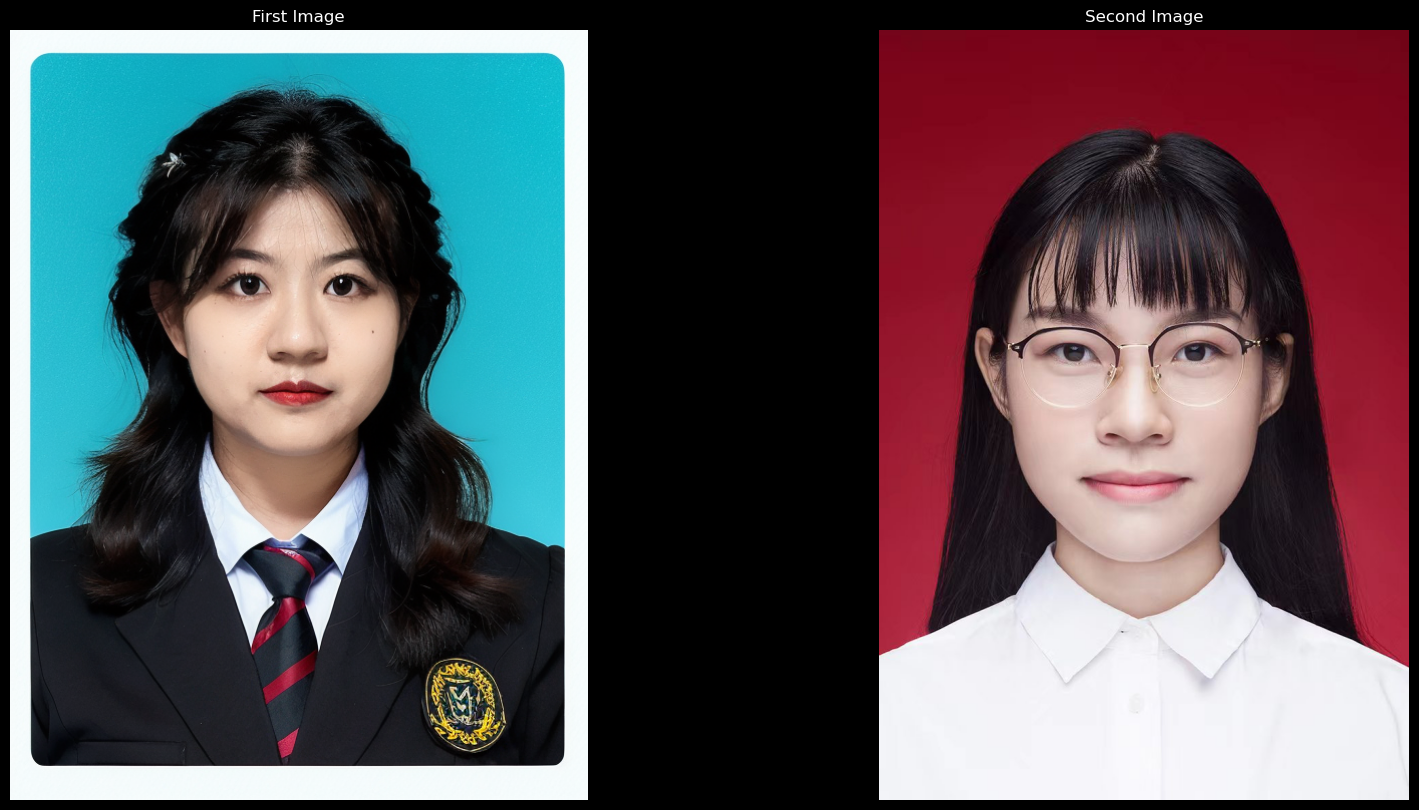

In [48]:
img1=plt.imread("wgy.jpg")
img2=plt.imread("hyc.jpg")


plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1) 
plt.imshow(img1)
plt.axis('off') 
plt.title('First Image')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Second Image')


# matplotlib读取的图像默认是以浮点数形式归一化到[0, 1]的范围，而不是8位整数[0, 255]
# 将图像数据类型转换为uint8
if img1.dtype == np.float32: 
    img1 = (img1 * 255).astype(np.uint8)
    
if img2.dtype == np.float32: 
    img2 = (img2 * 255).astype(np.uint8)


Text(0.5, 1.0, 'Second Image')

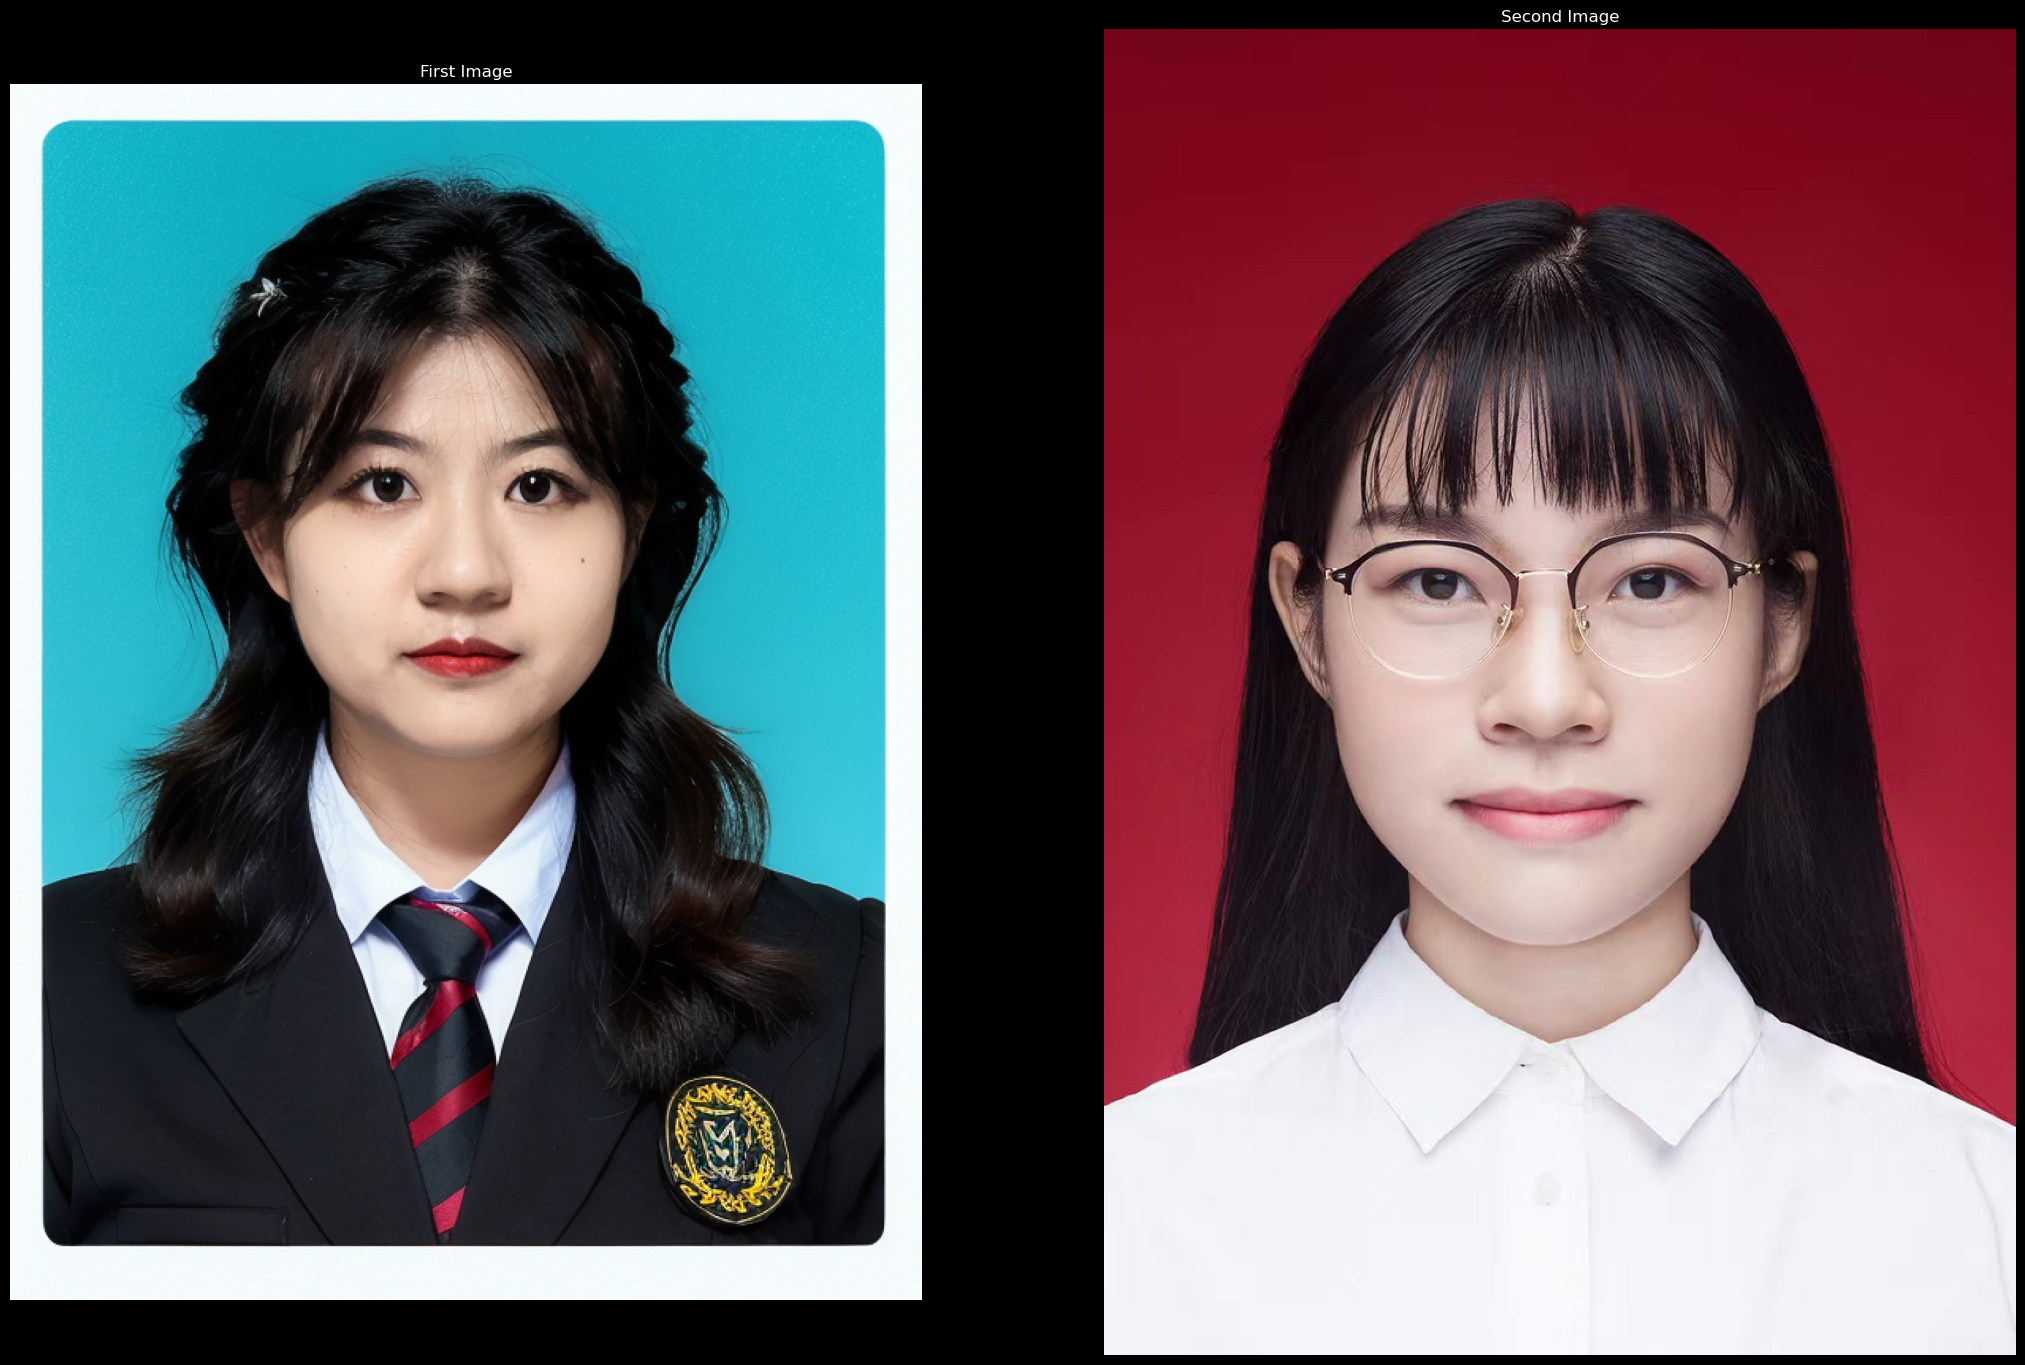

In [49]:
def get_feature_points(img):
    # 初始化面部检测器
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    # detector的输出是一个矩形列表，每个矩形代表检测到的人脸在图像中的位置，左上角和右下角的坐标
    # 1代表将上采样一次
    faces = detector(img, 1)

    # 存储特征点的坐标
    points=[]

    #遍历所有面部
    for k, d in enumerate(faces):
        # 在面部区域检测特征点
        # 返回一个dlib.full_object_detection对象，它包含了检测到的所有特征点的位置。可以通过索引访问每个特征点的坐标
        features = predictor(img, d)
        # print(features.part(0))
        # 存储每一个面部68个特征点的坐标（虽然一张照片只有一张脸）
        for i in range(68):
            point = (features.part(i).x, features.part(i).y)
            points.append(point)
            #cv2.circle(img, point, 3, (0, 0, 255), -1)
            #cv2.putText(img, str(i), point, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)
            
    return points,img

points1,img1 = get_feature_points(img1)
points2, img2 = get_feature_points(img2)  
  
# print("feature_points1: ",points1)
# print("feature_points2: ",points2)

plt.figure(figsize=(40, 20))

plt.subplot(1, 3, 1) 
plt.imshow(img1)
plt.axis('off') 
plt.title('First Image')

plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Second Image')


triangle_indices:  [(36, 0, 17), (0, 36, 1), (31, 2, 41), (2, 31, 3), (47, 29, 42), (29, 47, 35), (2, 1, 41), (29, 31, 40), (31, 29, 30), (31, 50, 49), (50, 31, 32), (4, 3, 48), (7, 59, 58), (59, 7, 6), (5, 4, 48), (50, 33, 51), (33, 50, 32), (6, 5, 48), (13, 35, 14), (35, 13, 54), (1, 36, 41), (8, 7, 58), (9, 8, 57), (10, 9, 55), (40, 37, 38), (37, 40, 41), (11, 10, 54), (37, 19, 38), (19, 37, 18), (12, 11, 54), (18, 37, 17), (13, 12, 54), (39, 27, 28), (27, 39, 21), (17, 37, 36), (15, 14, 46), (40, 38, 39), (16, 15, 45), (42, 29, 28), (0, 18, 17), (46, 14, 35), (19, 23, 20), (23, 19, 24), (21, 22, 27), (22, 21, 20), (19, 20, 38), (20, 23, 22), (15, 46, 45), (20, 21, 38), (42, 27, 22), (27, 42, 28), (42, 22, 43), (47, 44, 46), (44, 47, 43), (22, 23, 43), (44, 25, 26), (25, 44, 24), (23, 24, 43), (26, 16, 45), (35, 30, 29), (30, 35, 34), (35, 54, 53), (3, 31, 48), (28, 29, 39), (9, 56, 55), (56, 9, 57), (31, 49, 48), (58, 62, 57), (62, 58, 61), (31, 30, 32), (51, 63, 66), (63, 51, 52),

Text(0.5, 1.0, 'Second Image')

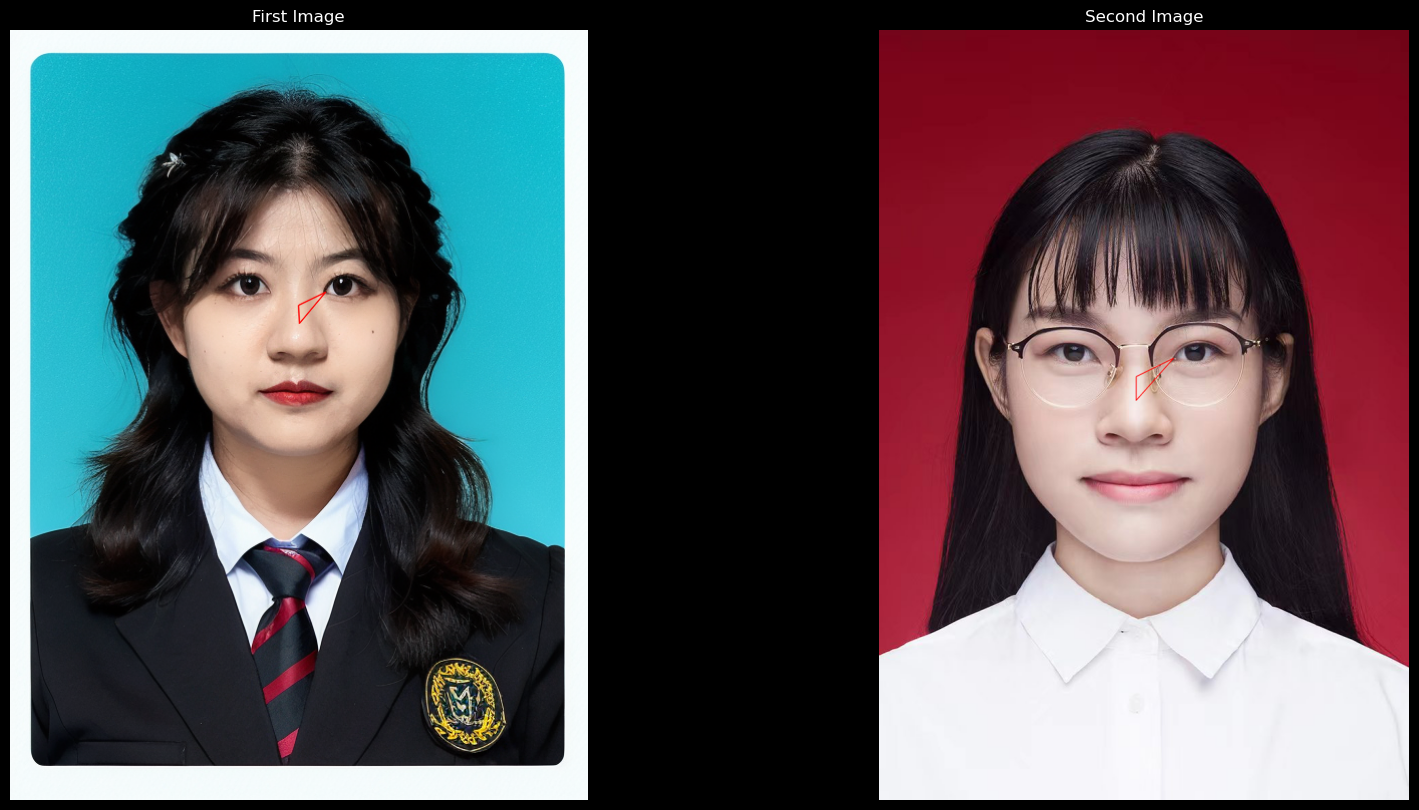

In [50]:
#要确保不同图像的三角剖分顺序相同啊啊啊啊!!!
#可以首先在一张基准图上执行Delaunay三角剖分，然后使用得到的顶点索引来在另一张图上重建相同的三角形
#它将返回顶点索引的列表而不是坐标，以确保三角剖分的一致性
def get_triangles_indices(img, points):
    height, width, channels = img.shape
    # 定义一个和图片尺寸相同的矩形
    rect = (0, 0, width, height)
    # OpenCV中用于Delaunay三角剖分的类subdiv 
    subdiv = cv2.Subdiv2D(rect)
    # 将所有关键点坐标插入到实例中
    for point in points:
        subdiv.insert(point)
    # 获取三角剖分的结果,包含构成三角形的顶点坐标
    triangleList = subdiv.getTriangleList()
    #print(triangleList)
    #需要将三角形顶点的坐标都转化为整数，不然cv2没法画图了
    triangleList = np.array(triangleList, dtype=np.int32)
    triangle_indices = []
    for t in triangleList:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])
        # 确定特征点的索引
        index_pt1 = points.index(pt1)
        index_pt2 = points.index(pt2)
        index_pt3 = points.index(pt3)
        
        # 保存索引而非坐标
        triangle_indices.append((index_pt1, index_pt2, index_pt3))
    print("triangle_indices: ",triangle_indices)
    return triangle_indices

def draw_triangles(img, points, triangle_indices):
    for index, (i, j, k) in enumerate(triangle_indices):
        pt1 = points[i]
        pt2 = points[j]
        pt3 = points[k]
        if(index==38):
            cv2.line(img, pt1, pt2, (255, 0, 0), 1, cv2.LINE_AA, 0)
            cv2.line(img, pt2, pt3, (255, 0, 0), 1, cv2.LINE_AA, 0)
            cv2.line(img, pt3, pt1, (255, 0, 0), 1, cv2.LINE_AA, 0)

    return img

triangle_indices = get_triangles_indices(img1,points1)
img1=draw_triangles(img1,points1,triangle_indices)
img2=draw_triangles(img2,points2,triangle_indices)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1) 
plt.imshow(img1)
plt.axis('off') 
plt.title('First Image')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Second Image')


In [51]:
def get_intermediate_points(points1,points2,alpha):
    points = []
    for i in range(len(points1)):
        x = (1 - alpha) * points1[i][0] + alpha * points2[i][0]
        y = (1 - alpha) * points1[i][1] + alpha * points2[i][1]
        points.append((x, y))
    return points
alpha = 0.5
#intermediate_points=get_intermediate_points(points1,points2,alpha)
# print(intermediate_points)


In [52]:
#计算仿射变换矩阵
def compute_affine_transform(begin,end):
    P = np.array([
        [begin[0][0], begin[0][1], 1, 0, 0, 0],
        [0, 0, 0, begin[0][0], begin[0][1], 1],
        [begin[1][0], begin[1][1], 1, 0, 0, 0],
        [0, 0, 0, begin[1][0], begin[1][1], 1],
        [begin[2][0], begin[2][1], 1, 0, 0, 0],
        [0, 0, 0, begin[2][0], begin[2][1], 1]
    ])
    P_ = np.array([
        end[0][0],
        end[0][1],
        end[1][0],
        end[1][1],
        end[2][0],
        end[2][1]
    ])

    P_inv = np.linalg.inv(P)
    
    # 用逆矩阵乘以B矩阵得到仿射变换参数
    affine_params = P_inv.dot(P_)
    #start end应该都是（3，2）的矩阵所以这个affine应该是（2，3）的矩阵吧
    affine_params = affine_params.reshape(2,3)
    #print(affine_params.shape)
    return affine_params


In [53]:
#双线性插值
def bilinear_interpolate(img, x, y):
    #（x0,y0)是左上角像素点
    x0 = int(x)
    y0 = int(y)
    #（x1,y1）是右下角像素点
    x1 = x0 + 1
    y1 = y0 + 1
    #左上像素值Ia，左下像素值Ib，右上Ic
    Ia = img[y0, x0]
    Ib = img[y1, x0]
    Ic = img[y0, x1]
    Id = img[y1, x1]
    #权重是根据目标点与邻近四个像素坐标的相对距离来计算的。
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)
    #使用加权平均的方法计算插值
    return wa * Ia + wb * Ib + wc * Ic + wd * Id

In [54]:
#获取三角形区域内所有像素点
def get_triangle_pixels(triangle):
    #tri的数据结构是这样的[[217 256][171 260][199 236]]
    #在调用 pointPolygonTest 之前，需要确保传入的多边形的坐标是正确的类型
    triangle = np.array(triangle, dtype=np.float32)
    pixels = []
    #首先获取三角形的边界 一个矩形
    xMin = int(np.min(triangle[:, 0]))
    xMax = int(np.max(triangle[:, 0]))
    yMin = int(np.min(triangle[:, 1]))
    yMax = int(np.max(triangle[:, 1]))
    #生成边界内的所有点
    for x in range(xMin, xMax + 1):
        for y in range(yMin, yMax + 1):
            #它用于检测一个点是否在一个多边形内部、外部或者正好在多边形的边界上
            #最后一个参数measureDist是一个布尔值，指示是否计算并返回点到多边形最近边的距离：
            if cv2.pointPolygonTest(triangle, (x, y), False) >= 0:
                pixels.append((x, y))
    return pixels

In [55]:
#应用逆仿射变换矩阵 将其从当前的坐标系映射回原始图像的坐标系中
def apply_affine_transform(pixels,affine_transform):
    affine_transform=np.array(affine_transform)
    transformed_pixels = []
    #由于 affine_transform 是2×3 的，它不能直接被逆转，因为只有方阵才有逆。
    #将 2x3的矩阵堆叠上001转化成3x3的增广矩阵，再切片取出前两行，得到了一个 2x3的逆仿射矩阵

    #print("affineshape:",affine_transform)
    # arr=np.array([[0, 0, 1]])
    # print(arr.shape)
    
    affine_augmented = np.vstack((affine_transform, np.array([0, 0, 1])[np.newaxis, :]))
    affine_inverse = np.linalg.inv(affine_augmented)[:2, :]
    for pixel in pixels:
        #创建了一个齐次坐标表示的像素位置，加一个1将仿射变换包含平移在内的操作统一成矩阵乘法
        pixel_homogeneous = np.array([pixel[0], pixel[1], 1])
        transformed_pixel = affine_inverse.dot(pixel_homogeneous)
        transformed_pixels.append(transformed_pixel)
    return transformed_pixels
    

triangle_indices [(36, 0, 17), (0, 36, 1), (31, 2, 41), (2, 31, 3), (47, 29, 42), (29, 47, 35), (2, 1, 41), (29, 31, 40), (31, 29, 30), (31, 50, 49), (50, 31, 32), (4, 3, 48), (7, 59, 58), (59, 7, 6), (5, 4, 48), (50, 33, 51), (33, 50, 32), (6, 5, 48), (13, 35, 14), (35, 13, 54), (1, 36, 41), (8, 7, 58), (9, 8, 57), (10, 9, 55), (40, 37, 38), (37, 40, 41), (11, 10, 54), (37, 19, 38), (19, 37, 18), (12, 11, 54), (18, 37, 17), (13, 12, 54), (39, 27, 28), (27, 39, 21), (17, 37, 36), (15, 14, 46), (40, 38, 39), (16, 15, 45), (42, 29, 28), (0, 18, 17), (46, 14, 35), (19, 23, 20), (23, 19, 24), (21, 22, 27), (22, 21, 20), (19, 20, 38), (20, 23, 22), (15, 46, 45), (20, 21, 38), (42, 27, 22), (27, 42, 28), (42, 22, 43), (47, 44, 46), (44, 47, 43), (22, 23, 43), (44, 25, 26), (25, 44, 24), (23, 24, 43), (26, 16, 45), (35, 30, 29), (30, 35, 34), (35, 54, 53), (3, 31, 48), (28, 29, 39), (9, 56, 55), (56, 9, 57), (31, 49, 48), (58, 62, 57), (62, 58, 61), (31, 30, 32), (51, 63, 66), (63, 51, 52), (

(-0.5, 575.5, 767.5, -0.5)

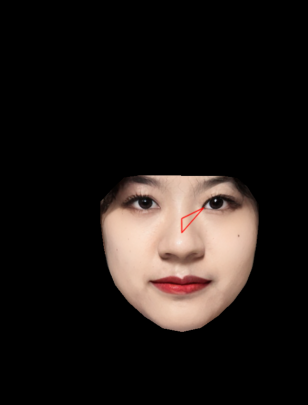

In [58]:
def get_intermediate_image(img1,img2,points1,points2,triangle_indices,alpha):
    # 创建一个空白的中间图像
    intermediate_image = np.zeros(img1.shape, dtype=img1.dtype)
    #alpha = 0.6

    # 初始化中间图像为第一个图像和第二个图像的按比例混合
    #intermediate_image = (alpha * img1 + (1 - alpha) * img2).astype(img1.dtype)

    print("triangle_indices",triangle_indices)
    print("points1[triangle_indices[0][0]]", points1[triangle_indices[0][0]])
    # 遍历每一个三角形的索引
    for i in range(len(triangle_indices)):
        # 获取三角形的顶点索引
        tri1_index = triangle_indices[i]
        tri2_index = triangle_indices[i]
        # 获取三角形的顶点坐标
        tri1_coordinate = np.array([points1[index] for index in tri1_index], np.int32)
        tri2_coordinate = np.array([points2[index] for index in tri2_index], np.int32) 
        tri_intermediate = get_intermediate_points(tri1_coordinate,tri2_coordinate,alpha)
        # 提取三角形区域所有像素点
        triangle_pixels = get_triangle_pixels(tri_intermediate)
        # print(tri1_coordinate)
        # print("tri_intermediate",tri_intermediate)
        
        #计算仿射变换
        affine_transform = compute_affine_transform(tri1_coordinate, tri_intermediate)
        print("affine_transform1: ",affine_transform)
        # 应用逆仿射变换来找到源图像中对应的像素位置
        src_pixels = apply_affine_transform( triangle_pixels,affine_transform)
        # 对于源图像中的每个像素位置，使用双线性插值找到像素值，并将其映射到中间图像
        for i, pixel in enumerate(triangle_pixels):
            src_x, src_y = src_pixels[i][0], src_pixels[i][1]
            # 双线性插值
            if 0 <= src_x < img1.shape[1]-1 and 0 <= src_y < img1.shape[0]-1:
                pixel_value = bilinear_interpolate(img1, src_x, src_y)
                intermediate_image[pixel[1], pixel[0]] = pixel_value
    return intermediate_image
intermediate_image=get_intermediate_image(img1,img2,points1,points2,triangle_indices,0.6)  
plt.figure(figsize=(10, 5)) 
plt.imshow(intermediate_image)
plt.axis('off') 
    

In [57]:
alphas = np.linspace(0, 1, 11)
#print(alphas)
intermediate_images=[]
# 设置保存图像的目录
save_dir = "result_images" 
for i,alpha in enumerate(alphas):
    intermediate_image=get_intermediate_image(img1,img2,points1,points2,triangle_indices,alpha)
    intermediate_images.append(intermediate_image)
    filename = f"frame_{i:02d}.jpg"  
    filepath = os.path.join(save_dir, filename)
    # 保存图像前确认图像是在正确的BGR颜色空间
    intermediate_image = cv2.cvtColor(intermediate_images[i], cv2.COLOR_RGB2BGR)
    # 保存图像
    cv2.imwrite(filepath, intermediate_image)









triangle_indices [(36, 0, 17), (0, 36, 1), (31, 2, 41), (2, 31, 3), (47, 29, 42), (29, 47, 35), (2, 1, 41), (29, 31, 40), (31, 29, 30), (31, 50, 49), (50, 31, 32), (4, 3, 48), (7, 59, 58), (59, 7, 6), (5, 4, 48), (50, 33, 51), (33, 50, 32), (6, 5, 48), (13, 35, 14), (35, 13, 54), (1, 36, 41), (8, 7, 58), (9, 8, 57), (10, 9, 55), (40, 37, 38), (37, 40, 41), (11, 10, 54), (37, 19, 38), (19, 37, 18), (12, 11, 54), (18, 37, 17), (13, 12, 54), (39, 27, 28), (27, 39, 21), (17, 37, 36), (15, 14, 46), (40, 38, 39), (16, 15, 45), (42, 29, 28), (0, 18, 17), (46, 14, 35), (19, 23, 20), (23, 19, 24), (21, 22, 27), (22, 21, 20), (19, 20, 38), (20, 23, 22), (15, 46, 45), (20, 21, 38), (42, 27, 22), (27, 42, 28), (42, 22, 43), (47, 44, 46), (44, 47, 43), (22, 23, 43), (44, 25, 26), (25, 44, 24), (23, 24, 43), (26, 16, 45), (35, 30, 29), (30, 35, 34), (35, 54, 53), (3, 31, 48), (28, 29, 39), (9, 56, 55), (56, 9, 57), (31, 49, 48), (58, 62, 57), (62, 58, 61), (31, 30, 32), (51, 63, 66), (63, 51, 52), (

IndexError: index 768 is out of bounds for axis 0 with size 768